In [246]:
import numpy as np
import pandas as pd
from collections import Counter
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [152]:
def filter_df(df, species, epitopes, chains, cdr3_len):
    return df[(df['species'].isin(species)) &
              (df['antigen.epitope'].isin(epitopes)) &
              (df['gene'].isin(chains)) &
              (df['cdr3_len'] == cdr3_len)].copy()

In [10]:
def get_concervative_pos(df, q):
    start_pos = np.percentile(df['v.end'], q=q, interpolation='nearest')
    end_pos = np.percentile(df['j.start'], q=(100-q), interpolation='nearest') - 1
    return start_pos, end_pos

In [208]:
AMINO_ACIDS = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
AA_2_POS = {'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4,
            'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9,
            'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14,
            'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}
AA_N = 20

def get_blosum_matrix(df, start_pos, end_pos):
    cdr3_full = df.cdr3.apply(lambda x: pd.Series(list(x))).values
    cdr3 = cdr3_full[:, start_pos:(end_pos+1)]

    # Frequency table
    F_ij = np.zeros([AA_N, AA_N])
    for j in range(0, cdr3.shape[1]):
        column_acids = cdr3[:, j]
        cnt = Counter(column_acids)
        for i_acid, i in AA_2_POS.items():
            for j_acid, j in AA_2_POS.items():
                if (i_acid == j_acid) and cnt[i_acid] > 1:
                    F_ij[i, j] += ((cnt[i_acid] * (cnt[i_acid] - 1)) / 2)
                else:
                    F_ij[i, j] += cnt[i_acid] * cnt[j_acid]
    
    # Observed probability
    lower_Tr = np.tril(np.ones([AA_N, AA_N]))
    np.fill_diagonal(lower_Tr, 1)
    total_pairs = np.sum(lower_Tr * F_ij)
    Q_ij = F_ij / total_pairs

    # Expected probability
    P_i = np.zeros(AA_N)
    for i_acid, i in AA_2_POS.items():
        P_i[i] = Q_ij[i, i] + (np.sum(Q_ij[i, :]) - Q_ij[i, i])/2
    E_ij = np.zeros([AA_N, AA_N])
    for i in np.arange(0, AA_N):
        for j in np.arange(0, AA_N):
            if i == j:
                E_ij[i, j] = P_i[i] * P_i[i]
            else:
                E_ij[i, j] = 2 * P_i[i] * P_i[j]
    
    # The log-odds ration
    L = np.zeros([AA_N, AA_N])
    for i in np.arange(0, AA_N):
        for j in np.arange(0, AA_N):
            if (Q_ij[i, j] == 0) or (E_ij[i, j] == 0):
                L[i, j] = 1
            else:
                L[i, j] = Q_ij[i, j] / E_ij[i, j]
    L = np.round(np.log2(L) * 2)
    return L

#### Database preparing

In [202]:
vdjdb_slim_df = pd.read_csv('../vdjdb-dump/vdjdb.slim.txt', sep='\t')

# Filter referencies from 10xgenomics.com
vdjdb_slim_df = vdjdb_slim_df[~vdjdb_slim_df['reference.id'].str.startswith('https://www.10xgenomics.com')]

# Filter bad positions of j.start and v.end
vdjdb_slim_df = vdjdb_slim_df[(vdjdb_slim_df['v.end'] < vdjdb_slim_df['j.start']) & (vdjdb_slim_df['v.end'] > 0)]

# add CDR3 len
vdjdb_slim_df['cdr3_len'] = vdjdb_slim_df.cdr3.str.len()

In [203]:
# Percentiles of samples number per species and gene. 
ept_df = vdjdb_slim_df.groupby(['species', 'gene', 'antigen.epitope', 'cdr3_len'])['cdr3'].count().reset_index()
ept_df.columns = ['species', 'gene', 'antigen.epitope', 'cdr3_len', 'samples_cnt']

In [204]:
# Leave just epitopes with >= 30 CDR3 samples
good_epitopes = ept_df[ept_df.samples_cnt >= 30][['species', 'gene', 'antigen.epitope', 'cdr3_len', 'samples_cnt']]
vdjdb_slim_df = vdjdb_slim_df.merge(good_epitopes, how='inner', suffixes=['', '_r'],
                                    left_on=['species', 'gene', 'antigen.epitope', 'cdr3_len'],
                                    right_on=['species', 'gene', 'antigen.epitope', 'cdr3_len'])


#### Build matrices for all good epitopes 

In [205]:
hs_tra_samples = good_epitopes[(good_epitopes.species == 'HomoSapiens') & (good_epitopes.gene == 'TRA')].shape[0]
hs_trb_samples = good_epitopes[(good_epitopes.species == 'HomoSapiens') & (good_epitopes.gene == 'TRB')].shape[0]
mm_tra_samples = good_epitopes[(good_epitopes.species == 'MusMusculus') & (good_epitopes.gene == 'TRA')].shape[0]
mm_trb_samples = good_epitopes[(good_epitopes.species == 'MusMusculus') & (good_epitopes.gene == 'TRB')].shape[0]
print(f"HomoSapiens good epitopes (TRA): {hs_tra_samples}")
print(f"HomoSapiens good epitopes (TRB): {hs_trb_samples}")
print(f"MusMusculus good epitopes (TRA): {mm_tra_samples}")
print(f"MusMusculus good epitopes (TRB): {mm_trb_samples}")

HomoSapiens good epitopes (TRA): 27
HomoSapiens good epitopes (TRB): 77
MusMusculus good epitopes (TRA): 15
MusMusculus good epitopes (TRB): 18


In [209]:
matrices = {}

for r in good_epitopes.to_records():
    species, chain, epitope, cdr3_len = r[1], r[2], r[3], r[4]
    df = filter_df(vdjdb_slim_df, [species], [epitope], [chain], cdr3_len)
    start_pos, end_pos = get_concervative_pos(df, 80)
    L = get_blosum_matrix(df, cdr3_start_pos, cdr3_end_pos)
    result = pd.DataFrame(L, index=AMINO_ACIDS, columns=AMINO_ACIDS)
    matrices[(species, chain, epitope, cdr3_len)] = result
    print(f"{species}, {chain}, {epitope}, {cdr3_len} processed!")

HomoSapiens, TRA, FRDYVDRFYKTLRAEQASQE, 12 processed!
HomoSapiens, TRA, GILGFVFTL, 10 processed!
HomoSapiens, TRA, GILGFVFTL, 11 processed!
HomoSapiens, TRA, GILGFVFTL, 12 processed!
HomoSapiens, TRA, GILGFVFTL, 13 processed!
HomoSapiens, TRA, GILGFVFTL, 14 processed!
HomoSapiens, TRA, GILGFVFTL, 15 processed!
HomoSapiens, TRA, GILGFVFTL, 16 processed!
HomoSapiens, TRA, GILGFVFTL, 17 processed!
HomoSapiens, TRA, GILGFVFTL, 18 processed!
HomoSapiens, TRA, GILGFVFTL, 19 processed!
HomoSapiens, TRA, GLIYNRMGAVTTEV, 14 processed!
HomoSapiens, TRA, LLLGIGILV, 11 processed!
HomoSapiens, TRA, LLLGIGILV, 12 processed!
HomoSapiens, TRA, LLLGIGILV, 13 processed!
HomoSapiens, TRA, LLLGIGILV, 14 processed!
HomoSapiens, TRA, LLLGIGILV, 15 processed!
HomoSapiens, TRA, LLWNGPMAV, 10 processed!
HomoSapiens, TRA, NLVPMVATV, 10 processed!
HomoSapiens, TRA, NLVPMVATV, 11 processed!
HomoSapiens, TRA, NLVPMVATV, 12 processed!
HomoSapiens, TRA, NLVPMVATV, 13 processed!
HomoSapiens, TRA, NLVPMVATV, 14 proces

#### Compare HomoSapiens TCA/TCB matrices

In [214]:
tca_matrices = []
tca_matrices_samples_n = []
tca_epitopes = good_epitopes[(good_epitopes.species == 'HomoSapiens') & (good_epitopes.gene == 'TRA')].values
for species, chain, epitope, e_len, n_samples in tca_epitopes:
    tca_matrices.append(matrices[(species, chain, epitope, e_len)])
    tca_matrices_samples_n.append(n_samples)

tcb_matrices = []
tcb_matrices_samples_n = []
tcb_epitopes = good_epitopes[(good_epitopes.species == 'HomoSapiens') & (good_epitopes.gene == 'TRB')].values
for species, chain, epitope, e_len, n_samples in tcb_epitopes:
    tcb_matrices.append(matrices[(species, chain, epitope, e_len)])
    tcb_matrices_samples_n.append(n_samples)

Average matrices values

In [239]:
avg_tca_result_matrix = pd.DataFrame(index=AMINO_ACIDS, columns=AMINO_ACIDS).fillna(0)
for matrix in tca_matrices:
    avg_tca_result_matrix += matrix
avg_tca_result_matrix = np.round(avg_tca_result_matrix / len(tca_matrices))

In [238]:
avg_tcb_result_matrix = pd.DataFrame(index=AMINO_ACIDS, columns=AMINO_ACIDS).fillna(0)
for matrix in tcb_matrices:
    avg_tcb_result_matrix += matrix
avg_tcb_result_matrix = np.round(avg_tcb_result_matrix / len(tcb_matrices))

Text(0.5, 1.0, 'Homo Sapiens, TCA/TCB difference, average values')

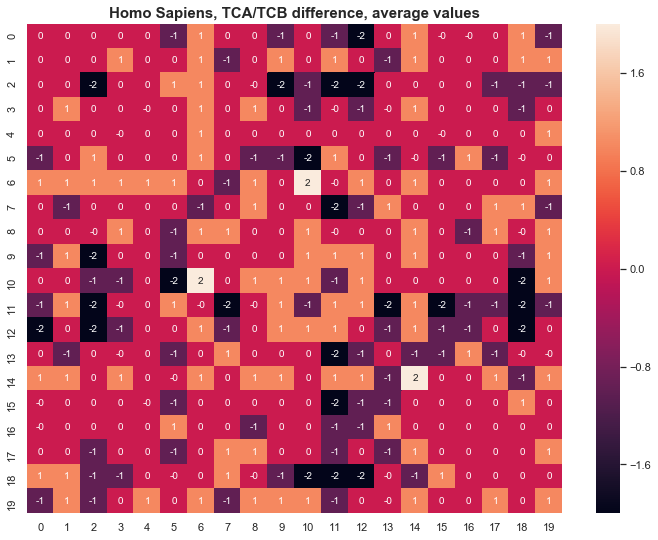

In [254]:
plt.figure(figsize=(12, 9))
sns.heatmap((avg_tca_result_matrix - avg_tcb_result_matrix).values, annot=True)
plt.title('Homo Sapiens, TCA/TCB difference, average values', fontsize=15, weight='bold')

Weighted average matrices values

In [243]:
w_avg_tca_result_matrix = pd.DataFrame(index=AMINO_ACIDS, columns=AMINO_ACIDS).fillna(0)
for idx, matrix in enumerate(tca_matrices):
    w_avg_tca_result_matrix += (matrix * tca_matrices_samples_n[idx])
w_avg_tca_result_matrix = np.round(w_avg_tca_result_matrix / np.sum(tca_matrices_samples_n))

In [245]:
w_avg_tcb_result_matrix = pd.DataFrame(index=AMINO_ACIDS, columns=AMINO_ACIDS).fillna(0)
for idx, matrix in enumerate(tcb_matrices):
    w_avg_tcb_result_matrix += (matrix * tcb_matrices_samples_n[idx])
w_avg_tcb_result_matrix = np.round(w_avg_tcb_result_matrix / np.sum(tcb_matrices_samples_n))

Text(0.5, 1.0, 'Homo Sapiens, TCA/TCB difference, weighted average values')

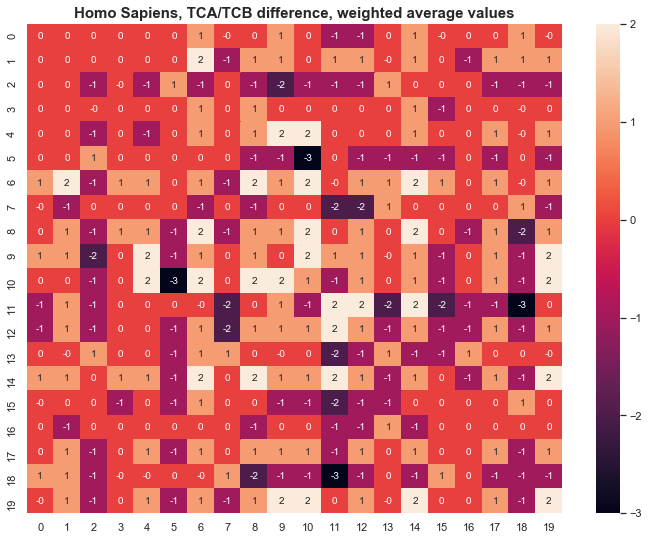

In [255]:
plt.figure(figsize=(12, 9))
sns.heatmap((w_avg_tca_result_matrix - w_avg_tcb_result_matrix).values, annot=True)
plt.title('Homo Sapiens, TCA/TCB difference, weighted average values', fontsize=15, weight='bold')

#### Simple example, Homo Sapiens, GIL antigen, TRB, Len14, GILGFVFTL

In [267]:
species, chain, epitope, cdr3_len = 'HomoSapiens', 'TRB', 'GILGFVFTL', 14
df = filter_df(vdjdb_slim_df, [species], [epitope], [chain], cdr3_len)
start_pos, end_pos = get_concervative_pos(df, 80)
L = get_blosum_matrix(df, cdr3_start_pos, cdr3_end_pos)
result = pd.DataFrame(L, index=AMINO_ACIDS, columns=AMINO_ACIDS)
result

,A,R,N,D,C,Q,E,G,H,I,L,K,M,F,P,S,T,W,Y,V
A,0.0,0.0,1.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-1.0,-0.0,-0.0,-1.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
R,0.0,1.0,-1.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
N,1.0,-1.0,2.0,-0.0,0.0,-1.0,0.0,-1.0,1.0,-2.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,1.0,0.0,2.0,0.0
D,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-1.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-1.0,-0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q,-0.0,-0.0,-1.0,0.0,0.0,1.0,-0.0,-0.0,-0.0,1.0,1.0,0.0,1.0,0.0,1.0,-0.0,-0.0,0.0,-0.0,-0.0
E,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
G,-0.0,0.0,-1.0,0.0,0.0,-0.0,0.0,1.0,-0.0,-2.0,-1.0,-0.0,-1.0,-1.0,-1.0,0.0,-0.0,-0.0,-1.0,-0.0
H,0.0,-0.0,1.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,1.0,-0.0
I,-1.0,-0.0,-2.0,-1.0,0.0,1.0,-0.0,-2.0,-0.0,2.0,2.0,1.0,2.0,1.0,2.0,-1.0,-1.0,1.0,0.0,0.0


In [268]:
print(f'N(D)N start position: {start_pos}, end position: {end_pos}')

N(D)N start position: 5, end position: 7


In [270]:
df['v_len_arr'] = df['v.end']
df['cdr3_len_arr'] = df['j.start'] - df['v.end']
df['j_len_arr'] = CDR3_LEN - df['j.start']

In [274]:
plot_sample_n = 100
plot_df = df.sample(plot_sample_n, random_state=42).sort_values(['cdr3_len_arr', 'v_len_arr'])
traces = []
traces.append(go.Bar(x=plot_df.v_len_arr, orientation='h', name='V'))
traces.append(go.Bar(x=plot_df.cdr3_len_arr, orientation='h', name='N(D)N'))
traces.append(go.Bar(x=plot_df.j_len_arr, orientation='h', name='J'))
traces.append(go.Scatter(x=[start_pos, start_pos], y=[0, plot_sample_n],
                         name='N(D)N start, 80%', line={'color': 'black'}))
traces.append(go.Scatter(x=[end_pos+1, end_pos+1], y=[0, plot_sample_n],
                         name='N(D)N end, 80%', line={'color': 'black'}))
fig = go.Figure(data=traces)
fig.update_layout(barmode='stack', title='HomoSapiens, GIL, TRB, Len: 14')
fig.show()